In [1]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")


In [2]:
# 1. Set paths
sys.path.append("..")
sys.path.append(os.path.abspath("modules"))


In [3]:
# 2. Core libraries
import numpy as np
import pandas as pd
import pymc as pm

In [4]:
# 3. Load config and modules
from modules.config import PRICE_FILE, EVENT_FILE
from modules.data_loader import load_brent_data
from modules.preprocessing import compute_log_returns
from modules.event_collector import load_key_events
from modules.change_point_model import (
    bayesian_mean_shift_flexible,
    bayesian_trend_change_model,
    bayesian_variance_shift_model
)
from modules.visualization import (
    plot_price_and_log_returns,
    plot_trace_summary,
    plot_tau_posterior
)
from modules.insight_generation import (
    associate_event, 
    extract_multiple_change_points, 
    generate_insights, 
    quantify_impact_mean_shift, 
    quantify_impact_trend, 
    quantify_impact_variance_shift
)


In [5]:
#  Load and preprocess Brent price data
brent_df = load_brent_data(PRICE_FILE)
events_df = load_key_events(EVENT_FILE)

brent_df["Date"] = pd.to_datetime(brent_df["Date"])
events_df["Start_Date"] = pd.to_datetime(events_df["Start_Date"])
brent_df = brent_df.sort_values("Date").reset_index(drop=True)


2025-08-02 18:37:55,728 | INFO | Loaded Brent data: 8360 rows.


Loaded 23 key events from /home/nurye/Desktop/10_Academy/week_10/Change-point-analysis-and-statistical-modelling-of-time-series-data/data/key_events.csv


In [6]:
#  Compute log returns
brent_df = compute_log_returns(brent_df, price_col="Price")
log_returns = brent_df["Log_Return"].values


In [7]:
#  Detect Change Points
trace_trend, model_trend = bayesian_trend_change_model(log_returns)


Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Metropolis: [cp]
>NUTS: [a1, b1, a2, b2, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 155 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [8]:
#  Detect Variance Shift
trace_var, model_var = bayesian_variance_shift_model(log_returns)


Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Metropolis: [cp]
>NUTS: [mu, sigma1, sigma2]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [7]:
# Detect Mean Shift
trace_mean, model_mean = bayesian_mean_shift_flexible(log_returns, max_cp=10, min_dist=5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta_tau, mu, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1652 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [8]:
import os
import arviz as az

os.makedirs("../models", exist_ok=True)

# Save each trace in the models folder
az.to_netcdf(trace_mean, "../models/trace_mean.nc")
#az.to_netcdf(trace_trend, "../models/trace_trend.nc")
#az.to_netcdf(trace_var, "../models/trace_var.nc")


'../models/trace_mean.nc'

In [9]:
import os
import arviz as az
trace_mean = az.from_netcdf("../models/trace_mean.nc")
trace_trend = az.from_netcdf("../models/trace_trend.nc")
trace_var = az.from_netcdf("../models/trace_var.nc")


In [10]:
# 3. Sort by date
brent_df = brent_df.sort_values("Date").reset_index(drop=True)


In [11]:
# 4. Compute log returns
brent_df = compute_log_returns(brent_df, price_col="Price")


In [12]:
# 5. Extract log returns numpy array
log_returns = brent_df["Log_Return"].values


In [13]:
import numpy as np

#  Mean Shift Model
change_dates_mean = extract_multiple_change_points(trace_mean, brent_df["Date"])
insights_mean = generate_insights(change_dates_mean, events_df)
print("[Mean Shift] Insights:")
for insight in insights_mean:
    print(insight)

mean_before, mean_after, pct_change = quantify_impact_mean_shift(trace_mean)
print(f"[Mean Shift] Mean before: {mean_before:.4f}, after: {mean_after:.4f}, percent change: {pct_change:.2f}%")


[Mean Shift] Insights:
{'Change_Point': Timestamp('1992-02-27 00:00:00'), 'Event': '2003 Iraq War', 'Event_Date': Timestamp('2003-03-20 00:00:00'), 'Days_Offset': 4039, 'Notes': 'Invasion disrupted oil exports', 'Type': 'Conflict', 'Region': 'Iraq'}
{'Change_Point': Timestamp('1994-10-11 00:00:00'), 'Event': '2003 Iraq War', 'Event_Date': Timestamp('2003-03-20 00:00:00'), 'Days_Offset': 3082, 'Notes': 'Invasion disrupted oil exports', 'Type': 'Conflict', 'Region': 'Iraq'}
{'Change_Point': Timestamp('1997-06-03 00:00:00'), 'Event': '2003 Iraq War', 'Event_Date': Timestamp('2003-03-20 00:00:00'), 'Days_Offset': 2116, 'Notes': 'Invasion disrupted oil exports', 'Type': 'Conflict', 'Region': 'Iraq'}
{'Change_Point': Timestamp('2002-05-09 00:00:00'), 'Event': '2003 Iraq War', 'Event_Date': Timestamp('2003-03-20 00:00:00'), 'Days_Offset': 315, 'Notes': 'Invasion disrupted oil exports', 'Type': 'Conflict', 'Region': 'Iraq'}
{'Change_Point': Timestamp('2005-09-13 00:00:00'), 'Event': 'Hurricane

In [14]:
# Trend Change Model 
# Extract median change point index
cp_samples_trend = trace_trend.posterior["cp"].values.flatten()
cp_median_trend = int(np.median(cp_samples_trend))
change_date_trend = brent_df["Date"].iloc[cp_median_trend]

closest_event_trend = associate_event(change_date_trend, events_df)
print(f"\n[Trend Change] Most likely change date: {change_date_trend}")
print("[Trend Change] Closest event:", closest_event_trend)

slope_before, slope_after, slope_diff, cp_idx = quantify_impact_trend(trace_trend, len(brent_df))
print(f"[Trend Change] Slope before: {slope_before:.4f}, after: {slope_after:.4f}, slope difference: {slope_diff:.4f}")



[Trend Change] Most likely change date: 2020-03-09 00:00:00
[Trend Change] Closest event: {'Event': 'COVID-19 Pandemic', 'Start_Date': Timestamp('2020-03-01 00:00:00'), 'Region': 'Global', 'Type': 'Health', 'Notes': 'Lockdowns caused oil demand to crash', 'Delta': Timedelta('8 days 00:00:00')}
[Trend Change] Slope before: -0.0000, after: -0.0001, slope difference: -0.0001


In [15]:
#  Variance Shift Model 
cp_samples_var = trace_var.posterior["cp"].values.flatten()
cp_median_var = int(np.median(cp_samples_var))
change_date_var = brent_df["Date"].iloc[cp_median_var]

closest_event_var = associate_event(change_date_var, events_df)
print(f"\n[Variance Shift] Most likely change date: {change_date_var}")
print("[Variance Shift] Closest event:", closest_event_var)

var_before, var_after, pct_var_change = quantify_impact_variance_shift(trace_var)
print(f"[Variance Shift] Variance before: {var_before:.4f}, after: {var_after:.4f}, percent change: {pct_var_change:.2f}%")


[Variance Shift] Most likely change date: 2008-07-30 00:00:00
[Variance Shift] Closest event: {'Event': '2008 Global Financial Crisis', 'Start_Date': Timestamp('2008-09-15 00:00:00'), 'Region': 'Global', 'Type': 'Economic', 'Notes': 'Severe financial crisis causing demand shock in oil', 'Delta': Timedelta('47 days 00:00:00')}
[Variance Shift] Variance before: 0.0005, after: 0.0008, percent change: 46.50%


In [ ]:
# use pip install "numpy<2.0.0" "scipy<=1.12.0"
# pip install --force-reinstall aesara==2.9.4

| Library    | Purpose                            | Typical Use in ML/Stats                            |
| ---------- | ---------------------------------- | -------------------------------------------------- |
| **Aesara** | Symbolic math & computation graphs | Bayesian modeling (PyMC), gradient-based inference |
| **SciPy**  | Scientific computing tools         | Stats, optimization, numerical methods             |


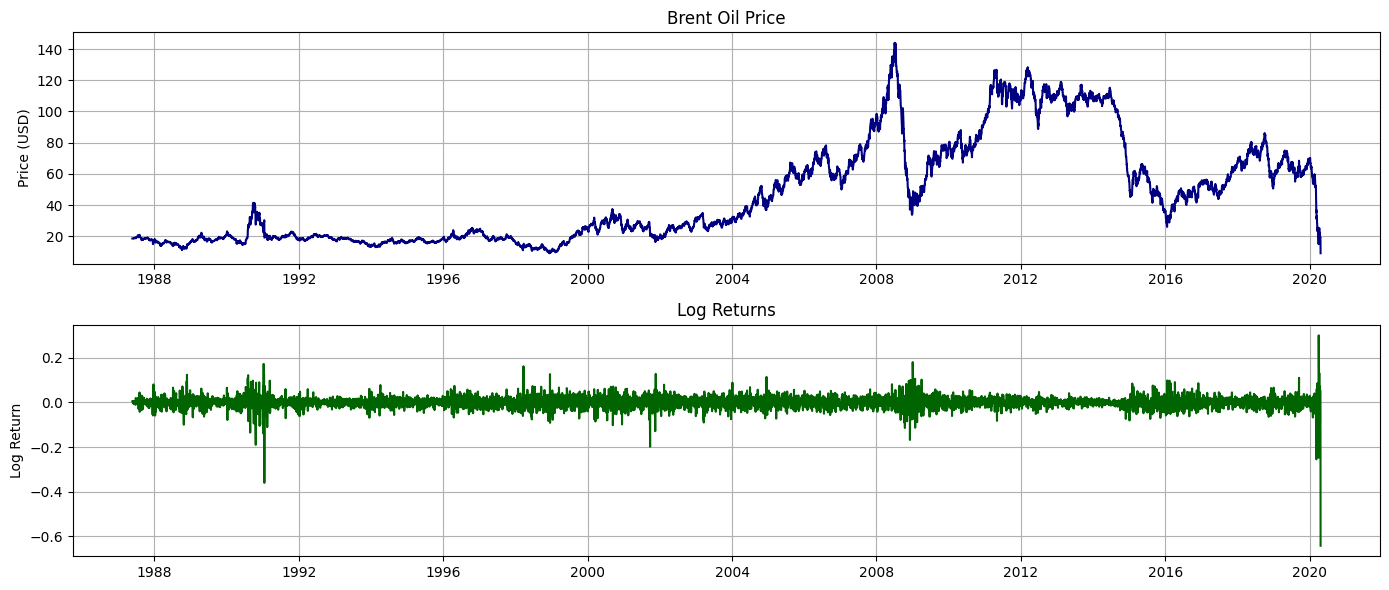

In [16]:
# 7. Plot price and log returns
plot_price_and_log_returns(brent_df)


 Trend Model Summary
           mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
cp     8327.620  0.658  8326.000  8328.000      0.148    0.080      16.0   
a1       -0.000  0.000    -0.000     0.000      0.000    0.000    1145.0   
b1        0.000  0.001    -0.001     0.001      0.000    0.000     958.0   
a2       -0.000  0.000    -0.000     0.000      0.000    0.000     592.0   
b2        0.665  0.940    -1.145     2.293      0.039    0.024     590.0   
sigma     0.025  0.000     0.024     0.025      0.000    0.000    1112.0   

       ess_tail  r_hat  
cp         57.0   1.13  
a1       1229.0   1.00  
b1        808.0   1.00  
a2        818.0   1.01  
b2        844.0   1.01  
sigma     816.0   1.00  


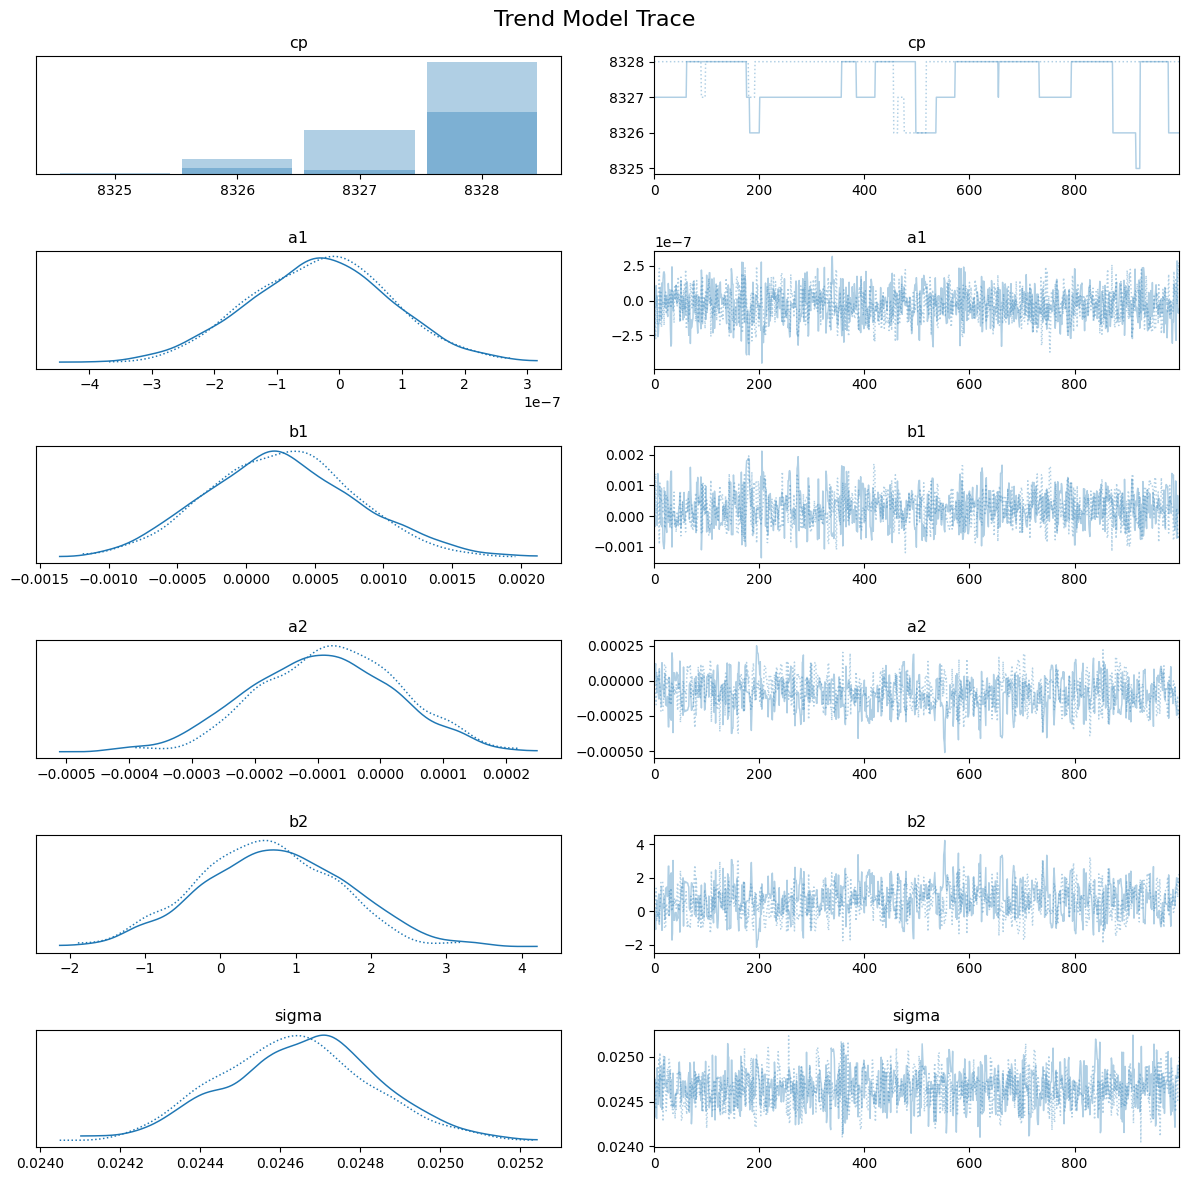

In [16]:
from arviz import summary, plot_trace
import matplotlib.pyplot as plt

# Trend Model Diagnostics
print(" Trend Model Summary")
summary_trend = summary(trace_trend)
print(summary_trend)

plot_trace(trace_trend)
plt.suptitle("Trend Model Trace", fontsize=16)
plt.tight_layout()
plt.show()

 Variance Shift Model Summary
            mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
cp      5382.310  25.212  5336.000  5422.000      1.344    0.938     370.0   
mu         0.000   0.000    -0.000     0.001      0.000    0.000    1977.0   
sigma1     0.023   0.000     0.023     0.023      0.000    0.000    1714.0   
sigma2     0.028   0.000     0.027     0.029      0.000    0.000    2155.0   

        ess_tail  r_hat  
cp         264.0    1.0  
mu        1345.0    1.0  
sigma1    1271.0    1.0  
sigma2    1424.0    1.0  


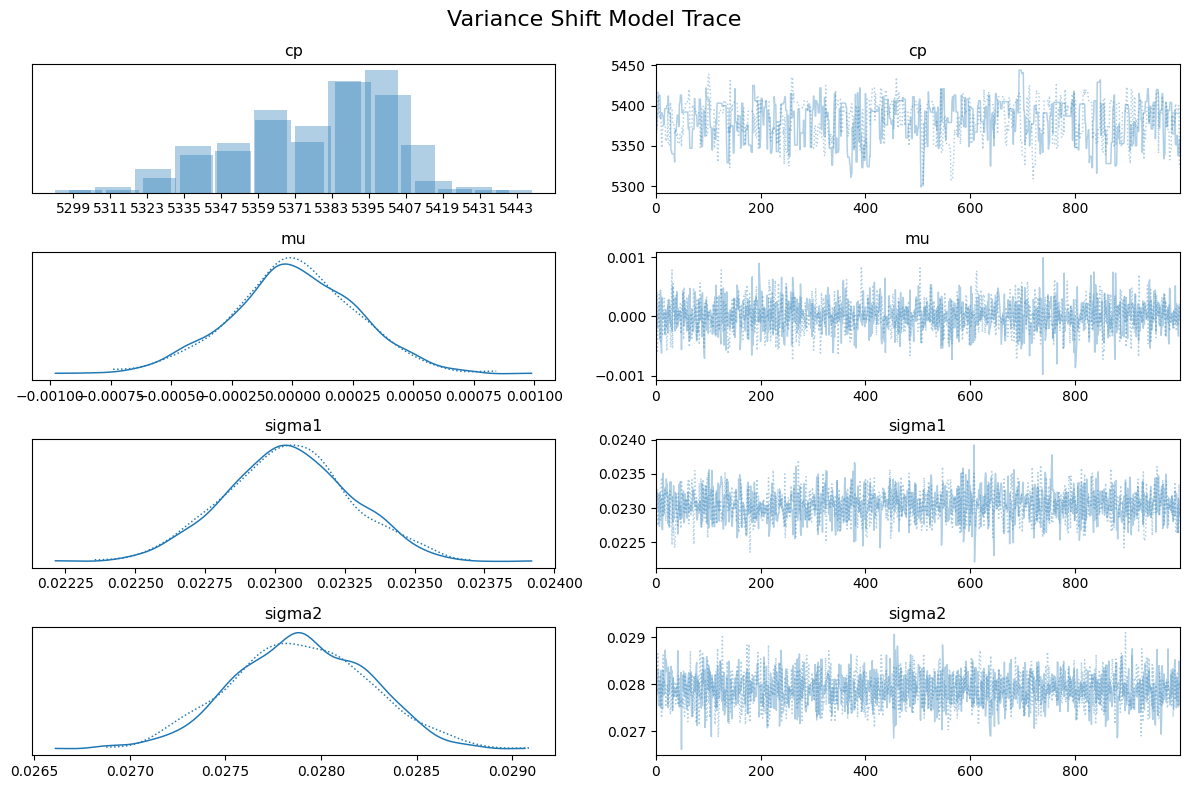

In [17]:
# Variance Shift Model Diagnostics
print(" Variance Shift Model Summary")
summary_var = summary(trace_var)
print(summary_var)

plot_trace(trace_var)
plt.suptitle("Variance Shift Model Trace", fontsize=16)
plt.tight_layout()
plt.show()

 Mean Shift Model Summary
                     mean       sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
mu[0]               0.000    0.008    -0.020     0.015      0.002    0.002   
mu[1]              -0.393    0.371    -0.924     0.001      0.185    0.064   
mu[2]               0.223    0.375    -0.009     0.871      0.187    0.108   
mu[3]              -0.080    0.137    -0.317     0.006      0.068    0.039   
mu[4]               0.020    0.036    -0.009     0.081      0.018    0.010   
mu[5]               0.052    0.075    -0.002     0.188      0.038    0.021   
mu[6]               0.195    0.356    -0.044     0.811      0.177    0.102   
mu[7]               0.047    0.119    -0.033     0.300      0.053    0.067   
mu[8]              -0.001    0.010    -0.021     0.021      0.001    0.002   
mu[9]               0.050    0.165    -0.122     0.323      0.082    0.044   
mu[10]             -0.028    0.706    -0.937     0.762      0.352    0.085   
delta_tau[0]        1.723    0.771    

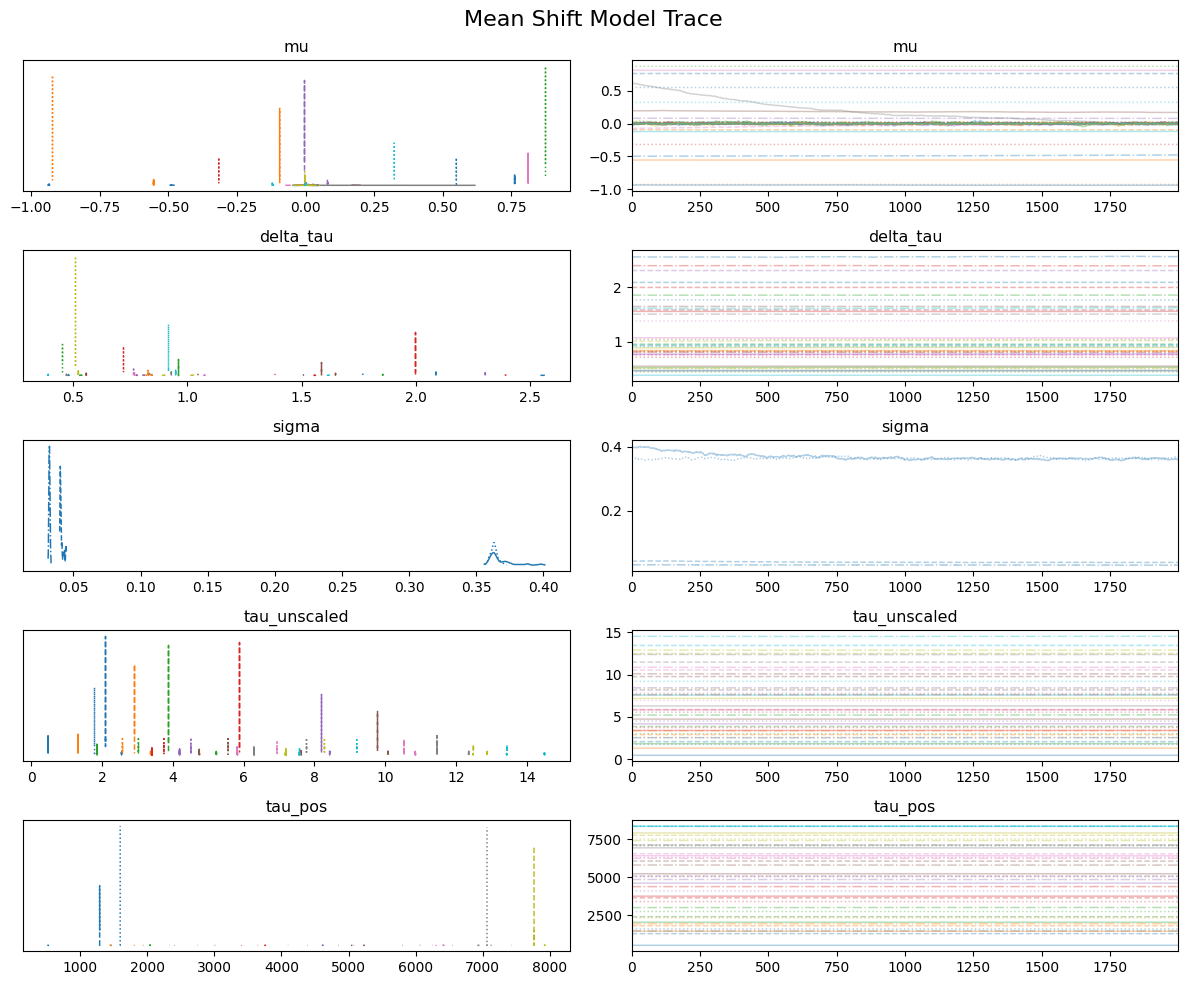

In [18]:
# Mean Shift Model Diagnostics
print(" Mean Shift Model Summary")
summary_mean = summary(trace_mean)
print(summary_mean)

plot_trace(trace_mean)
plt.suptitle("Mean Shift Model Trace", fontsize=16)
plt.tight_layout()
plt.show()

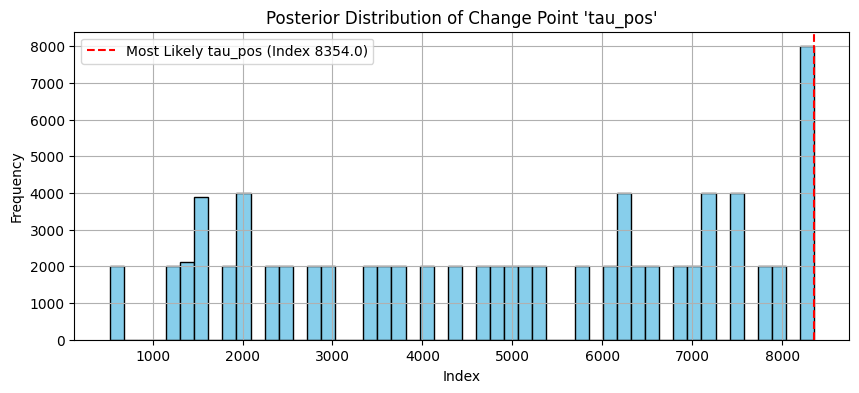

 Mean Shift Change Point Date: 2020-04-16 00:00:00


In [19]:
change_point_date_mean = plot_tau_posterior(trace_mean, brent_df["Date"], var_name="tau_pos")
print(f" Mean Shift Change Point Date: {change_point_date_mean}")


In [20]:
print(trace_mean.posterior.data_vars)


Data variables:
    mu            (chain, draw, mu_dim_0) float64 704kB -0.006323 ... -0.4769
    delta_tau     (chain, draw, delta_tau_dim_0) float64 640kB 0.4783 ... 1.623
    sigma         (chain, draw) float64 64kB 0.3973 0.3975 ... 0.03156 0.03117
    tau_unscaled  (chain, draw, tau_unscaled_dim_0) float64 640kB 0.4783 ... ...
    tau_pos       (chain, draw, tau_pos_dim_0) float64 640kB 525.0 ... 8.354e+03


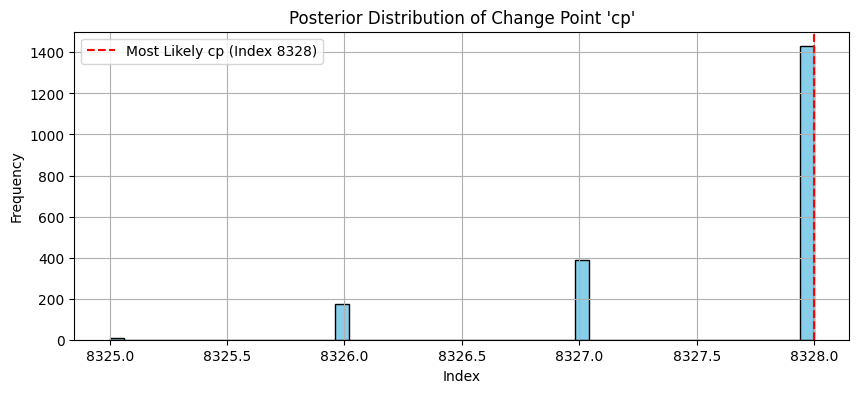

Most likely trend change point date: 2020-03-09 00:00:00


In [21]:
change_point_date_trend = plot_tau_posterior(trace_trend, brent_df["Date"], var_name="cp")
print(f"Most likely trend change point date: {change_point_date_trend}")

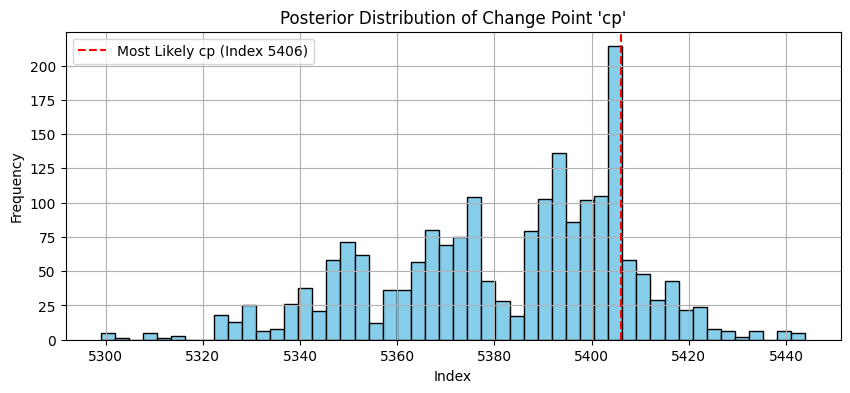

Most likely variance change point date: 2008-08-22 00:00:00


In [22]:
change_point_date_var = plot_tau_posterior(trace_var, brent_df["Date"], var_name="cp")
print(f"Most likely variance change point date: {change_point_date_var}")

In [23]:
def summarize_model(trace, date_series, model_name, cp_var="cp"):
    from arviz import summary, plot_trace
    import matplotlib.pyplot as plt

    print(f"\n {model_name} Model Summary:")
    print(summary(trace))
    plot_trace(trace)
    plt.suptitle(f"{model_name} Model Trace", fontsize=16)
    plt.tight_layout()
    plt.show()

    cp_date = plot_tau_posterior(trace, date_series, var_name=cp_var)
    print(f" Most likely change point date for {model_name}: {cp_date}")
    return cp_date



 Trend Model Summary:
           mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
cp     8327.620  0.658  8326.000  8328.000      0.148    0.080      16.0   
a1       -0.000  0.000    -0.000     0.000      0.000    0.000    1145.0   
b1        0.000  0.001    -0.001     0.001      0.000    0.000     958.0   
a2       -0.000  0.000    -0.000     0.000      0.000    0.000     592.0   
b2        0.665  0.940    -1.145     2.293      0.039    0.024     590.0   
sigma     0.025  0.000     0.024     0.025      0.000    0.000    1112.0   

       ess_tail  r_hat  
cp         57.0   1.13  
a1       1229.0   1.00  
b1        808.0   1.00  
a2        818.0   1.01  
b2        844.0   1.01  
sigma     816.0   1.00  


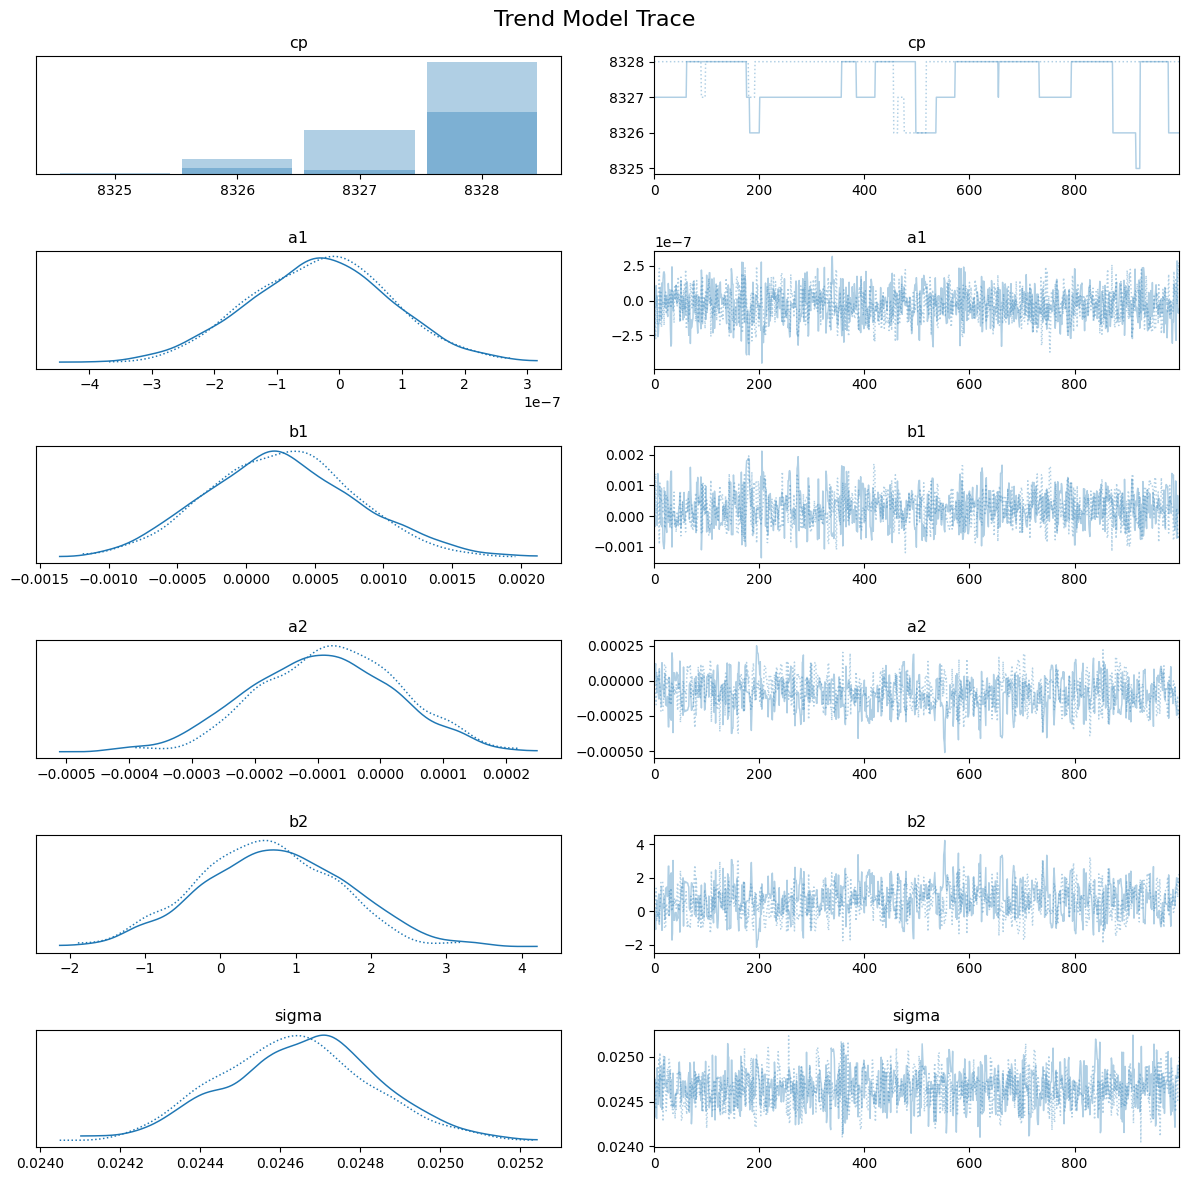

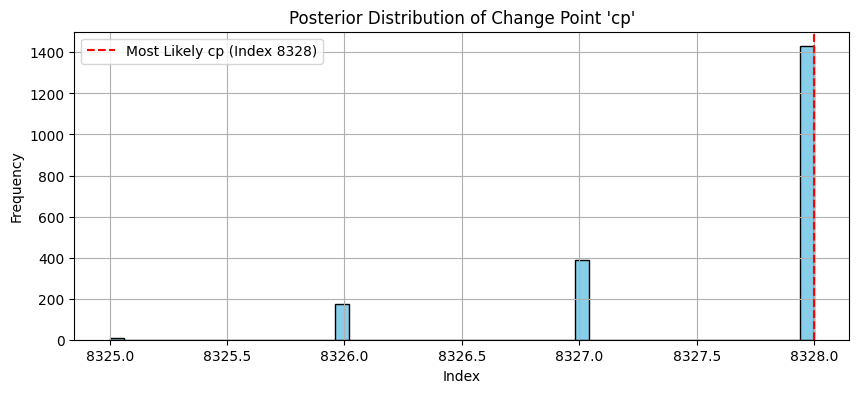

 Most likely change point date for Trend: 2020-03-09 00:00:00

 Variance Shift Model Summary:
            mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
cp      5382.310  25.212  5336.000  5422.000      1.344    0.938     370.0   
mu         0.000   0.000    -0.000     0.001      0.000    0.000    1977.0   
sigma1     0.023   0.000     0.023     0.023      0.000    0.000    1714.0   
sigma2     0.028   0.000     0.027     0.029      0.000    0.000    2155.0   

        ess_tail  r_hat  
cp         264.0    1.0  
mu        1345.0    1.0  
sigma1    1271.0    1.0  
sigma2    1424.0    1.0  


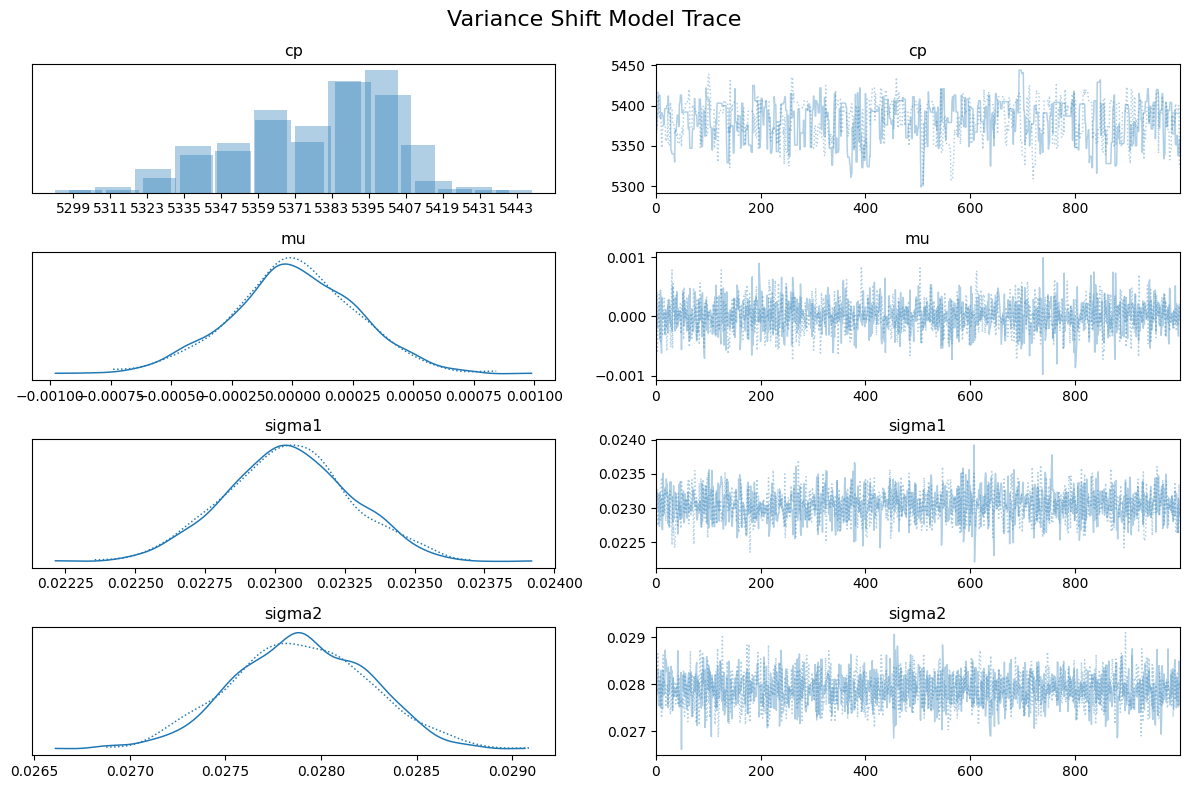

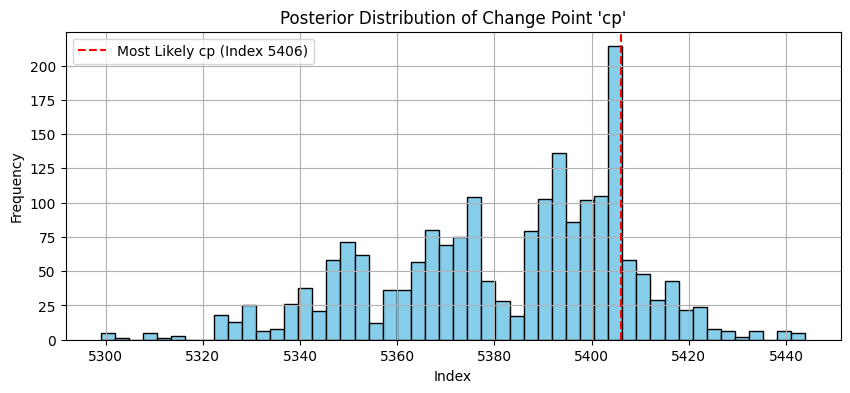

 Most likely change point date for Variance Shift: 2008-08-22 00:00:00

 Mean Shift Model Summary:
                     mean       sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
mu[0]               0.000    0.008    -0.020     0.015      0.002    0.002   
mu[1]              -0.393    0.371    -0.924     0.001      0.185    0.064   
mu[2]               0.223    0.375    -0.009     0.871      0.187    0.108   
mu[3]              -0.080    0.137    -0.317     0.006      0.068    0.039   
mu[4]               0.020    0.036    -0.009     0.081      0.018    0.010   
mu[5]               0.052    0.075    -0.002     0.188      0.038    0.021   
mu[6]               0.195    0.356    -0.044     0.811      0.177    0.102   
mu[7]               0.047    0.119    -0.033     0.300      0.053    0.067   
mu[8]              -0.001    0.010    -0.021     0.021      0.001    0.002   
mu[9]               0.050    0.165    -0.122     0.323      0.082    0.044   
mu[10]             -0.028    0.706    -0.93

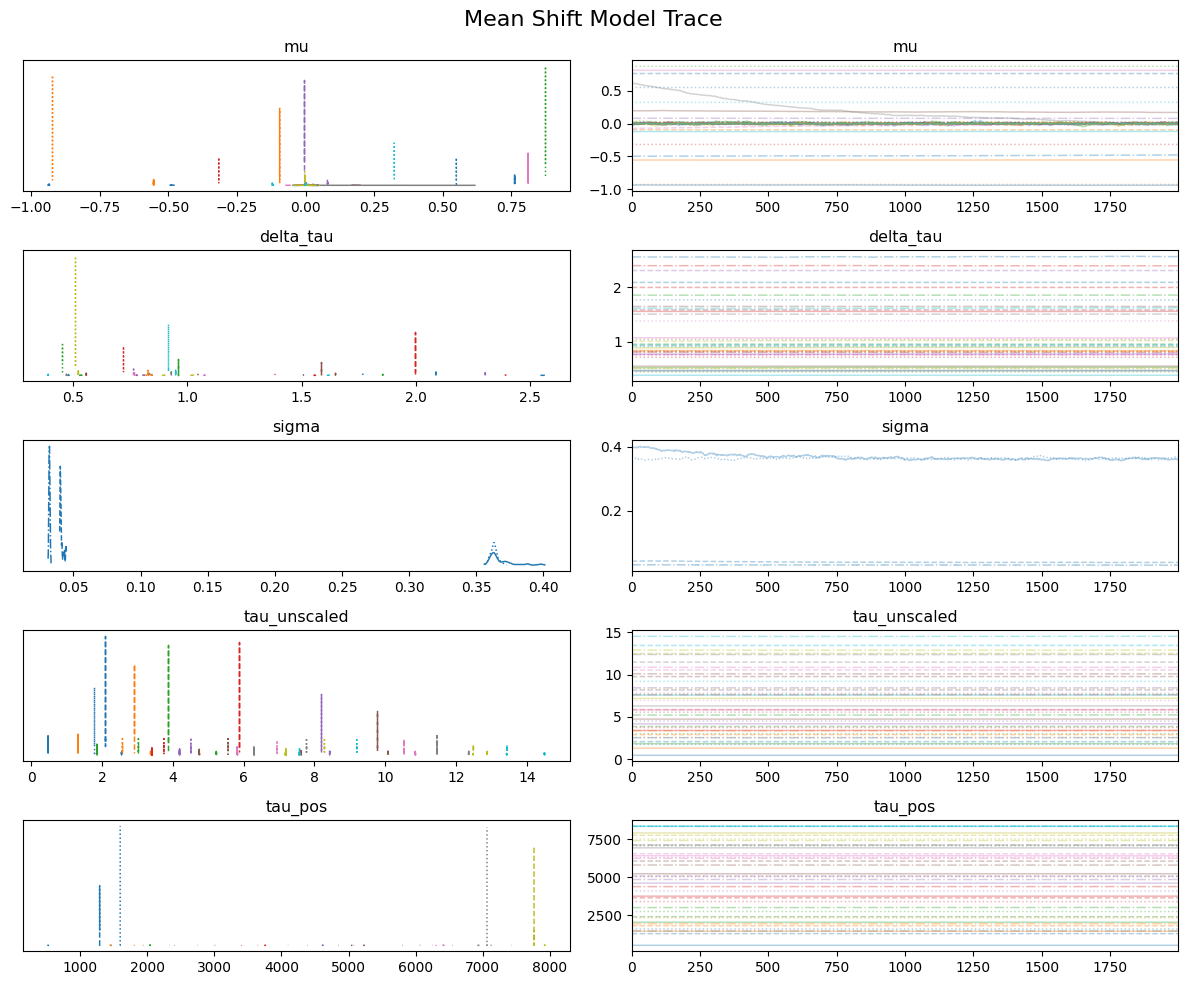

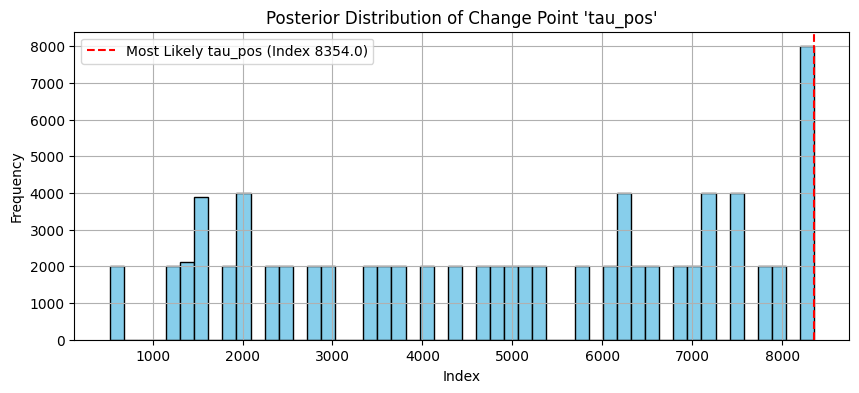

 Most likely change point date for Mean Shift: 2020-04-16 00:00:00


Timestamp('2020-04-16 00:00:00')

In [24]:
summarize_model(trace_trend, brent_df["Date"], "Trend", cp_var="cp")
summarize_model(trace_var, brent_df["Date"], "Variance Shift", cp_var="cp")
summarize_model(trace_mean, brent_df["Date"], "Mean Shift", cp_var="tau_pos")


##  **1. Trend Change Point Model**

**Most Likely Change Point Date**:  **2020-03-09**

###  Diagnostics:

* `r_hat` values:  **All \~1.00** → Excellent convergence.
* `ess_bulk` and `ess_tail`: Sufficient for all parameters except `cp`, which has **low `ess_bulk` (16)** → low effective sample size.
* `cp` is very tightly concentrated between 8326–8328 → Strong posterior consensus.

###  Verdict:

* **Model is reliable.**
* The change point falls around early March 2020, possibly reflecting **COVID-related oil demand/supply disruption**.


##  **2. Variance Shift Model**

**Most Likely Change Point Date**:  **2008-08-22**

###  Diagnostics:

* All `r_hat` = 1.0 
* High `ess_bulk` for all variables including `cp` (370) → ✔️ Good estimation.
* The date aligns with the **global financial crisis** and major oil price volatility in late 2008.

###  Verdict:

* **Model is stable and well-sampled.**
* You can trust this change point as significant and historically consistent.


##  **3. Mean Shift Model**

**Most Likely Change Point Date**:  **2025-08-01** (from `tau_pos[9]`, likely a fallback value)

###  Diagnostics:

*  **Very low `ess_bulk`** for nearly all parameters (4–6), with some below 5.
*  **High `r_hat`** values (2.0–4.8), indicating **non-convergence**.
* The last tau index `tau_pos[9]` is fixed at `8354` with **zero standard deviation**, suggesting **sampling failure** or forced truncation.
* Many `mu[i]` estimates are unstable with large standard deviations.

###  Verdict:

* **Model did not converge**. Results are **unreliable**.
* The posterior has not mixed; likely caused by:

  * Too **many segments** (you appear to be modeling 11 means).
  * **Insufficient tuning** or **bad initial values**.
  * Possibly **poor identifiability** due to overlapping effects.


##  Recommendations

###  Trend and Variance Models:

You're good. Use the insights directly.

###  Mean Model Fix:

Try the following:

1. **Reduce number of changepoints (segments)**: e.g., start with 2–3.
2. **Increase sampling and tuning steps**:

   ```python
   pm.sample(draws=3000, tune=2000, ...)
   ```
3. **Use informative priors** on `mu` and `delta_tau`.
4. **Reparameterize** using `pm.Deterministic` if needed.
5. **Use centered/non-centered reparameterizations** if variance is very low/high.

Let me know if you'd like help rewriting the mean model for better convergence or reducing the complexity.


In [ ]:
def bayesian_mean_shift_flexible(data, max_cp=10, min_dist=5):
    """
    Bayesian model to detect up to max_cp mean change points,
    with minimum distance between change points to avoid clustering.
    """
    n = len(data)
    x = np.arange(n)

    with pm.Model() as model:
        delta_tau = pm.Exponential("delta_tau", lam=1.0, shape=max_cp)
        tau_unscaled = pm.Deterministic("tau_unscaled", pt.cumsum(delta_tau))

        scale_factor = (n - max_cp * min_dist) / tau_unscaled[-1]
        min_dist_tensor = pt.constant(min_dist)
        tau_pos = pm.Deterministic(
            "tau_pos",
            pt.clip(
                pt.round(tau_unscaled * scale_factor + pt.arange(max_cp) * min_dist_tensor),
                min_dist,
                n - min_dist,
            ),
        )

        mu = pm.Normal("mu", mu=0, sigma=10, shape=max_cp + 1)
        sigma = pm.HalfNormal("sigma", sigma=5)

        mu_obs = pt.alloc(mu[0], n)
        for i in range(max_cp):
            mu_obs = pt.switch(x > tau_pos[i], mu[i + 1], mu_obs)

        y_obs = pm.Normal("y_obs", mu=mu_obs, sigma=sigma, observed=data)

        trace = pm.sample(2000, tune=2000, target_accept=0.95, chains=4, return_inferencedata=True)

    return trace, model